<div>
    <font face="Times New Roman" style="text-align: center;">
        <h1>Beyond Reviews</h1>
        <h2>Validating online consumer reviews using unsupervised machine learning methods.</h2>
        <p><strong>Date:</strong> June 15, 2024</p>
        <p><strong>Student:</strong> Maurits Christiaan Graaf</p>
        <p><strong>Studentnumber:</strong> 660509</p>
        <p><strong>Supervisor:</strong> Dr. D.J. (David) Kusterer</p>
        <p><strong>Second Reader:</strong> Dr. M. (Maciej) Szymanowski</p>
        <p><strong>Department:</strong> Marketing</p>
        <p><strong>University:</strong> Rotterdam School of Management</p>
    </font>
</div>

### Importing Packages
This codeblock imports the necessary packages.

In [14]:
##### ------ Importing Packages ------ #####
#General packages
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from joblib import Parallel, delayed

#Packages for cosine similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

#Packages for NLP and Sentiment
import re
from bs4 import BeautifulSoup
import nltk
from nltk.tokenize import sent_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer

### Dataset
The data is downloaded from HuggingFace and contains Amazon data in the following categories:
- All Beauty
- Amazon Fashion
- Appliances

These downloads contain both product metadata and review data. 
The data is constructed by:

Hou, Y., Li, J., He, Z., Yan, A., Chen, X., & McAuley, J. (2024). Bridging language and items for retrieval and recommendation. arXiv Preprint arXiv:2403.03952. https://arxiv.org/abs/2403.03952

- The data can be found on github: https://amazon-reviews-2023.github.io/
- or on HuggingFace: https://huggingface.co/datasets/McAuley-Lab/Amazon-Reviews-2023

#### Importing the datasets
The following codeblocks download the datasets and convert them to pandas data frame format.

In [15]:
# Load the All Beauty review dataset
reviews_all_beauty = load_dataset("McAuley-Lab/Amazon-Reviews-2023", "raw_review_All_Beauty", trust_remote_code=True)
# Convert to Pandas DataFrame
reviews_all_beauty_df = reviews_all_beauty["full"].to_pandas()

# Load the All Beauty metadata dataset
metadata_all_beauty = load_dataset("McAuley-Lab/Amazon-Reviews-2023", "raw_meta_All_Beauty", 
                                   split="full", 
                                   trust_remote_code=True)
# Convert to Pandas DataFrame
metadata_all_beauty_df = metadata_all_beauty.to_pandas()

# Define the batch size
batch_size = 10000

# Initialize an empty list to store the loaded data
reviews_data = []
metadata_data = []

# Load and process the data in batches
for i in range(0, len(reviews_all_beauty_df), batch_size):
    batch_reviews = reviews_all_beauty_df.iloc[i:i+batch_size]
    batch_metadata = metadata_all_beauty_df.iloc[i:i+batch_size]
        
    # Append the batched data to the list
    reviews_data.append(batch_reviews)
    metadata_data.append(batch_metadata)

# Concatenate the batched data into a single DataFrame
reviews_all_beauty_df = pd.concat(reviews_data, ignore_index=True)
metadata_all_beauty_df = pd.concat(metadata_data, ignore_index=True)

In [16]:
# Load the Appliances review dataset
reviews_appliances = load_dataset("McAuley-Lab/Amazon-Reviews-2023", "raw_review_Appliances", trust_remote_code=True)
# Convert to Pandas DataFrame
reviews_appliances_df = reviews_appliances["full"].to_pandas()

# Load the Appliances metadata dataset
metadata_appliances = load_dataset("McAuley-Lab/Amazon-Reviews-2023", "raw_meta_Appliances", 
                                   split="full", 
                                   trust_remote_code=True)
# Convert to Pandas DataFrame
metadata_appliances_df = metadata_appliances.to_pandas()

# Define the batch size
batch_size = 10000

# Initialize an empty list to store the loaded data
reviews_data = []
metadata_data = []

# Load and process the data in batches
for i in range(0, len(reviews_appliances_df), batch_size):
    batch_reviews = reviews_appliances_df.iloc[i:i+batch_size]
    batch_metadata = metadata_appliances_df.iloc[i:i+batch_size]
       
    # Append the batched data to the list
    reviews_data.append(batch_reviews)
    metadata_data.append(batch_metadata)

# Concatenate the batched data into a single DataFrame
reviews_appliances_df = pd.concat(reviews_data, ignore_index=True)
metadata_appliances_df = pd.concat(metadata_data, ignore_index=True)

In [17]:
# Load the Amazon Fashion review dataset
reviews_amazon_fashion = load_dataset("McAuley-Lab/Amazon-Reviews-2023", "raw_review_Amazon_Fashion", trust_remote_code=True)
# Convert to Pandas DataFrame
reviews_amazon_fashion_df = reviews_amazon_fashion["full"].to_pandas()

# Load the Amazon Fashion metadata dataset
metadata_amazon_fashion = load_dataset("McAuley-Lab/Amazon-Reviews-2023", "raw_meta_Amazon_Fashion", 
                                       split="full", 
                                       trust_remote_code=True)
# Convert to Pandas DataFrame
metadata_amazon_fashion_df = metadata_amazon_fashion.to_pandas()

# Define the batch size
batch_size = 10000

# Initialize an empty list to store the loaded data
reviews_data = []
metadata_data = []

# Load and process the data in batches
for i in range(0, len(reviews_amazon_fashion_df), batch_size):
    batch_reviews = reviews_amazon_fashion_df.iloc[i:i+batch_size]
    batch_metadata = metadata_amazon_fashion_df.iloc[i:i+batch_size]
       
    # Append the batched data to the list
    reviews_data.append(batch_reviews)
    metadata_data.append(batch_metadata)

# Concatenate the batched data into a single DataFrame
reviews_amazon_fashion_df = pd.concat(reviews_data, ignore_index=True)
metadata_amazon_fashion_df = pd.concat(metadata_data, ignore_index=True)


In [18]:
#Printing the total length of all imported data
print(len(metadata_all_beauty_df) + 
      len(metadata_amazon_fashion_df) + 
      len(metadata_appliances_df) +
      len(reviews_all_beauty_df) +
      len(reviews_amazon_fashion_df) +
      len(reviews_appliances_df))

6364097


#### Merging metadata and review data
The review data has a many to one relationship with the metadata, as one product could contain multiple reviews.
For that reason we use inner join command to create one dataset per category.

The following codeblock merges reviews and metadata based on a match in 'parent_asin' using inner join.

In [19]:
# Merge the All Beauty based on the 'parent_asin' column
merged_all_beauty_df = pd.merge(reviews_all_beauty_df, metadata_all_beauty_df, on='parent_asin', how='inner')

# Merge the Appliances DataFrames based on the 'parent_asin' column
merged_appliances_df = pd.merge(reviews_appliances_df, metadata_appliances_df, on='parent_asin', how='inner')

# Merge the Amazon Fashion DataFrames based on the 'parent_asin' column
merged_amazon_fashion_df = pd.merge(reviews_amazon_fashion_df, metadata_amazon_fashion_df, on='parent_asin', how='inner')

In [20]:
#Add a column containing the overall category as the appliances category indicator does contain sub-categories.

# Add 'overall_category' column to merged_all_beauty_df
merged_all_beauty_df['overall_category'] = 'All Beauty'

# Add 'overall_category' column to merged_appliances_df
merged_appliances_df['overall_category'] = 'Appliances'

# Add 'overall_category' column to merged_amazon_fashion_df
merged_amazon_fashion_df['overall_category'] = 'Amazon Fashion'

#### Concetenating the data frames
To keep the real-world distribution of the downloaded datasets but still reduce the records we randomly select in total 150,000 records from the merged datasets based on their current (real-life) distribution. 

- Define the total length of the combination of merged data frames
- Define the proportion of each category
- Define the size of the concatenated dataframe (150,000)
- Calculate the number of records to be imported based on the defined size
- Randomly select records in a sample data frame per category
- Concatenate these randomly selected records

In [21]:
# Calculate the proportions of each category in the concatenated DataFrame
total_samples = len(merged_all_beauty_df) + len(merged_appliances_df) + len(merged_amazon_fashion_df)

proportion_all_beauty = len(merged_all_beauty_df) / total_samples
proportion_appliances = len(merged_appliances_df) / total_samples
proportion_amazon_fashion = len(merged_amazon_fashion_df) / total_samples

In [22]:
# Define the desired total sample size
total_sample_size = 150000

# Calculate the sample sizes for each category based on their proportions
sample_size_all_beauty = int(total_sample_size * proportion_all_beauty)
sample_size_appliances = int(total_sample_size * proportion_appliances)
sample_size_amazon_fashion = int(total_sample_size * proportion_amazon_fashion)

In [23]:
# Randomly sample from each category based on the calculated sample sizes
merged_all_beauty_sample = merged_all_beauty_df.sample(n=min(sample_size_all_beauty, 
                                                             len(merged_all_beauty_df)), 
                                                       random_state=6)

merged_appliances_sample = merged_appliances_df.sample(n=min(sample_size_appliances, 
                                                             len(merged_appliances_df)), 
                                                       random_state=6)

merged_amazon_fashion_sample = merged_amazon_fashion_df.sample(n=min(sample_size_amazon_fashion, 
                                                                     len(merged_amazon_fashion_df)), 
                                                               random_state=6)

In [24]:
# Concatenate the sampled DataFrames vertically
concatenated_df = pd.concat([merged_all_beauty_sample, merged_appliances_sample, merged_amazon_fashion_sample])

# Reset the index of the concatenated DataFrame
concatenated_df.reset_index(drop=True, inplace=True)

#### Cleaning the concatenated data frame
Renaming columns for more clarity

In [25]:
#Renaming the columns
concatenated_df.rename(columns={
    'rating': 'Review_Rating',
    'title_x': 'Review_Title',
    'text': 'Review_Text',
    'images_x': 'Review_Images',
    'asin': 'Product_ASIN',
    'parent_asin': 'Parent_Product_ASIN',
    'user_id': 'User_ID',
    'timestamp': 'Review_Timestamp',
    'helpful_vote': 'Helpful_Votes',
    'verified_purchase': 'Verified_Purchase',
    'main_category': 'Main_Category',
    'title_y': 'Product_Title',
    'average_rating': 'Product_Average_Rating',
    'rating_number': 'Count_product_ratings',
    'features': 'Product_Features',
    'description': 'Product_Description',
    'price': 'Product_Price',
    'images_y': 'Product_Images',
    'videos': 'Product_Videos',
    'store': 'Product_Store',
    'categories': 'Product_Categories',
    'details': 'Product_Details',
    'bought_together': 'Products_Bought_Together',
    'subtitle': 'Product_Subtitle',
    'author': 'Product_Author'
}, inplace=True)

print(concatenated_df.columns)

Index(['Review_Rating', 'Review_Title', 'Review_Text', 'Review_Images',
       'Product_ASIN', 'Parent_Product_ASIN', 'User_ID', 'Review_Timestamp',
       'Helpful_Votes', 'Verified_Purchase', 'Main_Category', 'Product_Title',
       'Product_Average_Rating', 'Count_product_ratings', 'Product_Features',
       'Product_Description', 'Product_Price', 'Product_Images',
       'Product_Videos', 'Product_Store', 'Product_Categories',
       'Product_Details', 'Products_Bought_Together', 'Product_Subtitle',
       'Product_Author', 'overall_category'],
      dtype='object')


In [26]:
# Convert Review_Timestamp to normal date-time format
concatenated_df['Review_Timestamp'] = pd.to_datetime(concatenated_df['Review_Timestamp'], unit='ms')

# Print the converted Review_Timestamp column
print(concatenated_df['Review_Timestamp'])

0        2021-12-25 18:54:16.643
1        2019-12-29 17:11:57.390
2        2017-10-22 04:27:20.407
3        2017-01-15 22:57:18.000
4        2019-12-16 18:55:07.324
                   ...          
149993   2016-06-15 21:38:03.000
149994   2022-06-21 02:46:14.453
149995   2019-10-14 22:14:51.600
149996   2016-08-30 23:06:33.000
149997   2019-04-08 12:02:04.676
Name: Review_Timestamp, Length: 149998, dtype: datetime64[ns]


In [27]:
#Removing HTML Elements from Review_Text
# Function to remove HTML tags from text
def remove_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    clean_text = soup.get_text(separator=" ")
    return clean_text

# Apply the remove_html_tags function to the Review_Text column
concatenated_df['Review_Text'] = concatenated_df['Review_Text'].apply(remove_html_tags)

# Print the updated DataFrame
print(concatenated_df['Review_Text'])

C:\Users\Maurits\AppData\Local\Temp\ipykernel_30304\661356361.py:4: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")
C:\Users\Maurits\AppData\Local\Temp\ipykernel_30304\661356361.py:4: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


0                          Really does the job on my beard.
1         Just received our replacement bottle of Pura d...
2         Luv these bath cloths..  They are great at kee...
3         Scent is so light, fresh and clean.  Like noth...
4         I like it over all and I don’t know if this is...
                                ...                        
149993    I can always count of these Hanes briefs to be...
149994                                            Like this
149995                   Beautiful, can't want to wear them
149996                             Exactly as advertised :)
149997                    A little smaller than I expected!
Name: Review_Text, Length: 149998, dtype: object


### Feature engineering
The following section of the notebook engineers features that will be used in the statistical analyses performed in the thesis.

Features engineered:
- Review title length
- Review text (body) length
- Difference between rating and average product rating
- Review rank based on timestamp per product -> limitation of selecting randomly

In [28]:
# Calculate the length of every review title
concatenated_df['Review_Title_Length'] = concatenated_df['Review_Title'].apply(len)

In [29]:
# Calculate the length of every review text
concatenated_df['Review_Text_Length'] = concatenated_df['Review_Text'].apply(len)

In [30]:
#Difference review rating and average product rating
concatenated_df['Rating_Difference'] = concatenated_df['Review_Rating'] - concatenated_df['Product_Average_Rating']

In [31]:
# Convert Review_Timestamp to datetime if it's not already in datetime format
concatenated_df['Review_Timestamp'] = pd.to_datetime(concatenated_df['Review_Timestamp'])

# Sort the DataFrame by Parent_Product_ASIN and Review_Timestamp
concatenated_df = concatenated_df.sort_values(by=['Parent_Product_ASIN', 'Review_Timestamp'])

# Rank every review per product based on the time they were published
concatenated_df['Review_Rank'] = concatenated_df.groupby('Product_ASIN')['Review_Timestamp'].rank(ascending=True)

# Print a limited number of products
products_to_print = 5  # Adjust the number of products to print here
for parent_asin, group_df in concatenated_df.groupby('Parent_Product_ASIN'):
    print(f"Parent Product ASIN: {parent_asin}")
    print(group_df[['Parent_Product_ASIN', 'Review_Rank', 'Review_Timestamp']].head(25))
    print("\n")
    products_to_print -= 1
    if products_to_print <= 0:
        break

Parent Product ASIN: 0512239134
      Parent_Product_ASIN  Review_Rank        Review_Timestamp
96583          0512239134          1.0 2021-11-07 16:11:00.306


Parent Product ASIN: 0629150591
       Parent_Product_ASIN  Review_Rank        Review_Timestamp
93909           0629150591          1.0 2017-01-29 13:27:17.000
148314          0629150591          2.0 2019-06-19 00:00:59.510


Parent Product ASIN: 069267599X
     Parent_Product_ASIN  Review_Rank    Review_Timestamp
7267          069267599X          1.0 2016-12-02 16:42:57


Parent Product ASIN: 0956695930
       Parent_Product_ASIN  Review_Rank        Review_Timestamp
146580          0956695930          1.0 2015-09-21 12:51:50.000
118941          0956695930          2.0 2017-07-16 20:33:40.103


Parent Product ASIN: 0985393300
      Parent_Product_ASIN  Review_Rank    Review_Timestamp
17826          0985393300          1.0 2013-09-06 13:17:57




In [32]:
#Extreme rating
# Create a binary variable indicating if Review_Rating contains a 1 or a 5
concatenated_df['Extreme_Rating'] = concatenated_df['Review_Rating'].apply(lambda x: 1 if x in [1, 5] else 0)

In [33]:
# Compute the average Review_Text_Length for each unique Product_ASIN
average_text_length_per_product = concatenated_df.groupby('Product_ASIN')['Review_Text_Length'].mean().reset_index()
average_text_length_per_product.rename(columns={'Review_Text_Length': 'Average_Text_Length'}, inplace=True)

# Merge the average_text_length_per_product DataFrame back to the original DataFrame
concatenated_df = pd.merge(concatenated_df, average_text_length_per_product, on='Product_ASIN', how='left')

# Calculate the difference between a specific record's Review_Text_Length and its product's average
concatenated_df['Text_Length_Difference'] = concatenated_df['Review_Text_Length'] - concatenated_df['Average_Text_Length']

In [34]:
# Count the number of reviews per Product_ASIN
review_count_per_product = concatenated_df.groupby('Product_ASIN').size().reset_index(name='Review_Count')

# Merge the review_count_per_product DataFrame back to the original DataFrame
concatenated_df = pd.merge(concatenated_df, review_count_per_product, on='Product_ASIN', how='left')

# Create a binary column indicating if the review is singular
concatenated_df['Singular_Review'] = (concatenated_df['Review_Count'] == 1).astype(int)

In [35]:
# Find word count by tokenizing review text into words
concatenated_df['Review_Words'] = concatenated_df['Review_Text'].apply(lambda text: re.findall(r'\b\w+\b', text.lower()))

# Calculate review word count
concatenated_df['Review_Word_Count'] = concatenated_df['Review_Words'].apply(len)

In [36]:
# Function to count fully capitalized words in a text
def count_fully_capitalized_words(text):
    # Use regular expression to find fully capitalized words
    fully_capitalized_words = re.findall(r'\b[A-Z]+\b', text)
    # Filter out words with length greater than 1 (to exclude single-letter words)
    fully_capitalized_words = [word for word in fully_capitalized_words if len(word) > 1]
    # Return the count of fully capitalized words
    return len(fully_capitalized_words)

# Apply the function to calculate Fully_Capitalized_Words_Count
concatenated_df['Fully_Capitalized_Words_Count'] = concatenated_df['Review_Text'].apply(count_fully_capitalized_words)

# Calculate proportion of fully capitalized words based on word count
concatenated_df['Fully_Capitalized_Words_Proportion'] = concatenated_df['Fully_Capitalized_Words_Count'] / concatenated_df['Review_Word_Count']

#Multiply by 100
concatenated_df['Fully_Capitalized_Words_Proportion'] *= 100

# Fill NaN values in 'Fully_Capitalized_Words_Proportion' column with 0
concatenated_df['Fully_Capitalized_Words_Proportion'].fillna(0, inplace=True)

In [37]:
# Calculating the proportion of capital letters in every review text (excluding starting sentence words)
# Function to count capital letters excluding start of sentence letters
def count_capital_letters_excluding_start_of_sentence(text):
    # Find all words in the text
    words = re.findall(r'\b\w+\b', text)
    # Join the words back into text
    text_without_start_of_sentence = ' '.join(words)
    # Count capital letters excluding start of sentence letters
    count = sum(1 for char in text_without_start_of_sentence if char.isupper())
    return count

# Apply the function to calculate the count of capital letters excluding start of sentence letters
concatenated_df['Capital_Letters_Excluding_Start_Count'] = concatenated_df['Review_Text'].apply(count_capital_letters_excluding_start_of_sentence)

# Calculate the percentage of capital letters excluding start of sentence letters
concatenated_df['Capital_Letters_Excluding_Start_Percentage'] = (concatenated_df['Capital_Letters_Excluding_Start_Count'] / 
                                                                 concatenated_df['Review_Text_Length']) * 100

# Fill NaN values in 'Capital_Letters_Excluding_Start_Percentage' column with 0
concatenated_df['Capital_Letters_Excluding_Start_Percentage'].fillna(0, inplace=True)

In [38]:
# Function to count first-person singular pronouns in a text
def count_first_person_pronouns(text):
    # Define a list of first-person singular pronouns
    first_person_pronouns = ['i', 'me', 'my', 'mine']
    # Find all words in the text
    words = re.findall(r'\b\w+\b', text.lower())
    # Count first-person singular pronouns
    count = sum(1 for word in words if word in first_person_pronouns)
    return count

# Apply the function to calculate the count of first-person singular pronouns
concatenated_df['First_Person_Pronouns_Count'] = concatenated_df['Review_Text'].apply(count_first_person_pronouns)

# Calculate the ratio of first-person singular pronouns
concatenated_df['First_Person_Pronouns_Ratio'] = concatenated_df['First_Person_Pronouns_Count'] / concatenated_df['Review_Word_Count']

# Multiply the ratio by 100 to convert it to a percentage
concatenated_df['First_Person_Pronouns_Ratio'] *= 100

# Fill NaN values in 'First_Person_Pronouns_Ratio' column with 0
concatenated_df['First_Person_Pronouns_Ratio'].fillna(0, inplace=True)

In [39]:
# Function to calculate the ratio of exclamation sentences
def calculate_exclamation_sentence_ratio(text):
    # Tokenize the text into sentences
    sentences = sent_tokenize(text)
    # Count the number of sentences with exclamation marks
    exclamation_sentences_count = sum(1 for sentence in sentences if '!' in sentence)
    # Calculate the ratio of exclamation sentences
    if len(sentences) > 0:
        exclamation_sentence_ratio = exclamation_sentences_count / len(sentences)
    else:
        exclamation_sentence_ratio = 0
    return exclamation_sentence_ratio

# Apply the function to calculate the ratio of exclamation sentences
concatenated_df['Exclamation_Sentence_Ratio'] = concatenated_df['Review_Text'].apply(calculate_exclamation_sentence_ratio)

concatenated_df['Exclamation_Sentence_Ratio'] *= 100

# Print the first few rows to verify the results
print(concatenated_df[['Review_Text', 'Exclamation_Sentence_Ratio']].head(10))

                                         Review_Text  \
0                Cute casual top. Doesn’t fit tight.   
1                                           Perfect!   
2                                Durable. Well made.   
3                                   Super adorable!!   
4  Quite possibly the best and most accurate unde...   
5  Very well written, considering that English is...   
6  I bought this book before moving to Yokosuka l...   
7  This is a great guide for nurses in pediatric ...   
8          Loved the stories...my son took the book.   
9               Good book if you skip over the intro   

   Exclamation_Sentence_Ratio  
0                    0.000000  
1                  100.000000  
2                    0.000000  
3                  100.000000  
4                    0.000000  
5                    0.000000  
6                    0.000000  
7                   33.333333  
8                    0.000000  
9                    0.000000  


In [40]:
# Initialize the VADER sentiment analyzer
sid = SentimentIntensityAnalyzer()

# Define batch size
batch_size = 1000

# Initialize lists to store results
sentiment_scores = []

# Process the data in batches
for i in range(0, len(concatenated_df), batch_size):
    # Get batch of review texts
    batch_reviews = concatenated_df['Review_Text'].iloc[i:i+batch_size]
    
    # Calculate sentiment scores for each review text in the batch
    batch_scores = batch_reviews.apply(lambda x: sid.polarity_scores(x))
    
    # Append the scores to the list
    sentiment_scores.extend(batch_scores)

# Concatenate the results into a single DataFrame
sentiment_df = pd.DataFrame(sentiment_scores)

In [41]:
# Add the sentiment scores to concatenated_df
concatenated_df['Sentiment_Scores'] = sentiment_df['compound']

# Print the updated DataFrame to verify the results
print(concatenated_df[['Review_Text', 'Sentiment_Scores']].head(30))

                                          Review_Text  Sentiment_Scores
0                 Cute casual top. Doesn’t fit tight.            0.7964
1                                            Perfect!            0.6114
2                                 Durable. Well made.            0.2732
3                                    Super adorable!!            0.8264
4   Quite possibly the best and most accurate unde...            0.9942
5   Very well written, considering that English is...            0.3384
6   I bought this book before moving to Yokosuka l...            0.9109
7   This is a great guide for nurses in pediatric ...            0.7088
8           Loved the stories...my son took the book.            0.5994
9                Good book if you skip over the intro            0.4404
10  Gr8 Sunday school books! Been using this serie...            0.8164
11  I like the big blocks for each day.  Plenty of...            0.1531
12  Very roomy, large size means it never gets los...           

In [42]:
def compute_cosine_similarity(group):
    group = group.reset_index()  # Reset index and turn it into a column
    if 'Review_Text' not in group:
        return pd.DataFrame()
    if len(group['Review_Text']) <= 1:
        return pd.DataFrame()

    tfidf_vectorizer = TfidfVectorizer(stop_words='english')
    tfidf_matrix = tfidf_vectorizer.fit_transform(group['Review_Text'])
    similarity_matrix = cosine_similarity(tfidf_matrix)

    results = []
    for i in range(len(group)):
        for j in range(i + 1, len(group)):
            results.append({
                'index1': group.at[i, 'index'],  # Use 'at' for faster access to scalar values
                'index2': group.at[j, 'index'],
                'Cosine_Similarity': similarity_matrix[i, j]
            })
    
    return pd.DataFrame(results)

concatenated_df['index'] = concatenated_df.index  # Ensure every row has an 'index' column

# Use joblib to parallelize with a progress indicator
similarity_pairs = Parallel(n_jobs=-1, verbose=10)(
    delayed(compute_cosine_similarity)(group)
    for _, group in concatenated_df.groupby('Product_ASIN')
)
similarity_pairs = pd.concat(similarity_pairs, ignore_index=True)

# Merge the DataFrame with similarity scores
concatenated_df = pd.merge(concatenated_df, similarity_pairs, how='left', left_on='index', right_on='index1')

# Drop the unnecessary 'index' columns to clean up the DataFrame
concatenated_df = concatenated_df.drop(columns=['index', 'index1', 'index2'])

# Drop duplicates only on columns that do not include arrays or lists
# Specify columns which are known to be hashable and unique
concatenated_df = concatenated_df.drop_duplicates(subset=['Product_ASIN', 'Review_Text'])

# Explode the Cosine_Similarity column if it's not already scalar values
concatenated_df = concatenated_df.explode('Cosine_Similarity').reset_index(drop=True)

# Display the DataFrame with the updated similarity scores
print(concatenated_df[['Product_ASIN', 'Review_Text', 'Cosine_Similarity']])

##### ---- Depending on the PC takes a couple of minutes to run properly

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 113 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 149 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 189 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 210 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 233 tasks      | elapsed:  

       Product_ASIN                                        Review_Text  \
0        0512239134                Cute casual top. Doesn’t fit tight.   
1        0629150591                                           Perfect!   
2        0629150591                                Durable. Well made.   
3        069267599X                                   Super adorable!!   
4        0956695930  Quite possibly the best and most accurate unde...   
...             ...                                                ...   
149875   B07QDW1B3K  I’ve only had this on for a couple weeks but i...   
149876   B07QDW1B3K  These filters worth the money and you get the ...   
149877   B07QDW1B3K  THE GE WATER FILTER HAS A CHIP IN THE FILTER T...   
149878   B07QDW1B3K          Easy to install and well worth your money   
149879   B0C72LXXJY  I've been using a puck screen for a long time ...   

        Cosine_Similarity  
0                     NaN  
1                0.000000  
2                     NaN  

In [43]:
# If no cosine similarity it is imputed with 0 to avoid NaN in the dataset
concatenated_df['Cosine_Similarity'].fillna(0, inplace=True)

### Descriptive statistics
Compute the overall descriptive statistics for all relevant columns and per group/category

In [44]:
print(concatenated_df.columns)

Index(['Review_Rating', 'Review_Title', 'Review_Text', 'Review_Images',
       'Product_ASIN', 'Parent_Product_ASIN', 'User_ID', 'Review_Timestamp',
       'Helpful_Votes', 'Verified_Purchase', 'Main_Category', 'Product_Title',
       'Product_Average_Rating', 'Count_product_ratings', 'Product_Features',
       'Product_Description', 'Product_Price', 'Product_Images',
       'Product_Videos', 'Product_Store', 'Product_Categories',
       'Product_Details', 'Products_Bought_Together', 'Product_Subtitle',
       'Product_Author', 'overall_category', 'Review_Title_Length',
       'Review_Text_Length', 'Rating_Difference', 'Review_Rank',
       'Extreme_Rating', 'Average_Text_Length', 'Text_Length_Difference',
       'Review_Count', 'Singular_Review', 'Review_Words', 'Review_Word_Count',
       'Fully_Capitalized_Words_Count', 'Fully_Capitalized_Words_Proportion',
       'Capital_Letters_Excluding_Start_Count',
       'Capital_Letters_Excluding_Start_Percentage',
       'First_Person_Prono

In [45]:
# Define relevant columns for descriptive statistics
relevant_columns = ['Review_Rating', 'Review_Timestamp', 'Helpful_Votes', 'Product_Average_Rating', 'Count_product_ratings',
                   'Review_Text_Length', 'Rating_Difference', 'Review_Rank', 'Extreme_Rating', 'Text_Length_Difference',
                   'Review_Count', 'Singular_Review', 'Review_Word_Count', 'Fully_Capitalized_Words_Proportion', 
                    'Capital_Letters_Excluding_Start_Percentage', 'First_Person_Pronouns_Ratio', 'Exclamation_Sentence_Ratio',
                   'Sentiment_Scores', 'Cosine_Similarity']

# Overall descriptive statistics for concatenated_df
overall_descriptions = concatenated_df[relevant_columns].describe()
print("Overall Descriptive Statistics:")
print(overall_descriptions)

Overall Descriptive Statistics:
       Review_Rating               Review_Timestamp  Helpful_Votes  \
count  149880.000000                         149880  149880.000000   
mean        4.073479  2019-03-13 16:42:48.717687040       0.755218   
min         1.000000            2002-05-07 01:51:28       0.000000   
25%         3.000000  2017-05-25 01:16:55.750000128       0.000000   
50%         5.000000  2019-06-29 18:57:41.055500032       0.000000   
75%         5.000000  2021-03-03 01:12:49.966499840       0.000000   
max         5.000000     2023-09-11 00:55:53.696000     839.000000   
std         1.421296                            NaN       6.459327   

       Product_Average_Rating  Count_product_ratings  Review_Text_Length  \
count           149880.000000          149880.000000       149880.000000   
mean                 4.135772            2242.547725          155.123219   
min                  1.000000               1.000000            0.000000   
25%                  3.800000    

In [46]:
# Calculate the standard deviation of timestamps
std_timestamps = concatenated_df['Review_Timestamp'].std()

# Print the standard deviation of timestamps
print("Standard Deviation of Timestamps:", std_timestamps)

Standard Deviation of Timestamps: 911 days 09:21:17.241513472


In [47]:
print(concatenated_df['Singular_Review'].sum())

74587


In [48]:
# Per unique overall_category
unique_categories = concatenated_df['overall_category'].unique()
for category in unique_categories:
    category_df = concatenated_df[concatenated_df['overall_category'] == category]
    category_descriptions = category_df[relevant_columns].describe()
    print("\nDescriptive Statistics for overall_category:", category)
    print(category_descriptions)


Descriptive Statistics for overall_category: Amazon Fashion
       Review_Rating               Review_Timestamp  Helpful_Votes  \
count   70347.000000                          70347   70347.000000   
mean        3.974157  2018-11-29 23:48:44.217239040       0.577224   
min         1.000000            2002-05-07 01:51:28       0.000000   
25%         3.000000            2017-04-09 20:45:31       0.000000   
50%         5.000000  2018-12-27 01:06:25.947000064       0.000000   
75%         5.000000  2020-09-01 15:19:06.846500096       0.000000   
max         5.000000     2023-08-29 22:50:26.671000     462.000000   
std         1.425173                            NaN       3.717472   

       Product_Average_Rating  Count_product_ratings  Review_Text_Length  \
count            70347.000000           70347.000000        70347.000000   
mean                 3.954510             602.012140          140.105065   
min                  1.000000               1.000000            0.000000   
25% 

Calculate the average rating and standard deviation per group (category) and overall.

In [49]:
# Calculate descriptive statistics per unique 'overall_category'
stats_per_category = concatenated_df.groupby('overall_category')['Review_Rating'].describe()

# Calculate descriptive statistics for overall 'Review_Rating'
overall_stats = concatenated_df['Review_Rating'].describe()

print("Descriptive Statistics per Overall Category:")
print(stats_per_category)
print("\nOverall Descriptive Statistics:")
print(overall_stats)

Descriptive Statistics per Overall Category:
                    count      mean       std  min  25%  50%  75%  max
overall_category                                                      
All Beauty        19724.0  3.957463  1.496050  1.0  3.0  5.0  5.0  5.0
Amazon Fashion    70347.0  3.974157  1.425173  1.0  3.0  5.0  5.0  5.0
Appliances        59809.0  4.228561  1.376647  1.0  4.0  5.0  5.0  5.0

Overall Descriptive Statistics:
count    149880.000000
mean          4.073479
std           1.421296
min           1.000000
25%           3.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: Review_Rating, dtype: float64


### Appendix

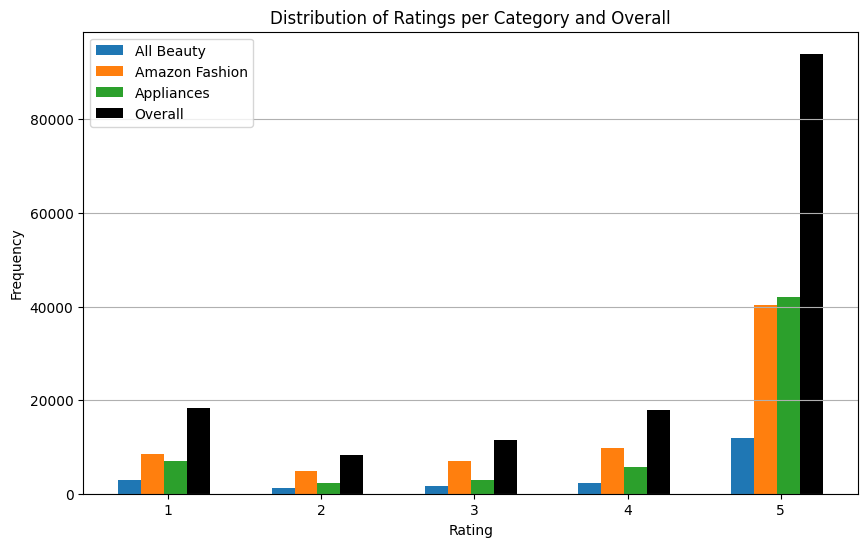

In [50]:
# Group by 'overall_category' and calculate the frequency of each rating
rating_counts_per_category = concatenated_df.groupby(['overall_category', 'Review_Rating']).size().unstack()

# Calculate overall rating frequency
overall_rating_counts = concatenated_df['Review_Rating'].value_counts().sort_index()

# Define the width of each bar
bar_width = 0.15

# Generate x-axis positions for each rating
x_values = np.arange(1, 6)

# Plotting
plt.figure(figsize=(10, 6))

# Plot each category's rating distribution
for i, (category, ratings) in enumerate(rating_counts_per_category.iterrows()):
    plt.bar(x_values + i * bar_width, ratings.values, width=bar_width, label=category)

# Plot overall rating distribution
plt.bar(x_values + len(rating_counts_per_category) * bar_width, overall_rating_counts.values, 
        width=bar_width, label='Overall', color='black')

# Set plot attributes
plt.title('Distribution of Ratings per Category and Overall')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.xticks(x_values + 0.25, x_values)
plt.legend()
plt.grid(axis='y')

# Show plot
plt.show()

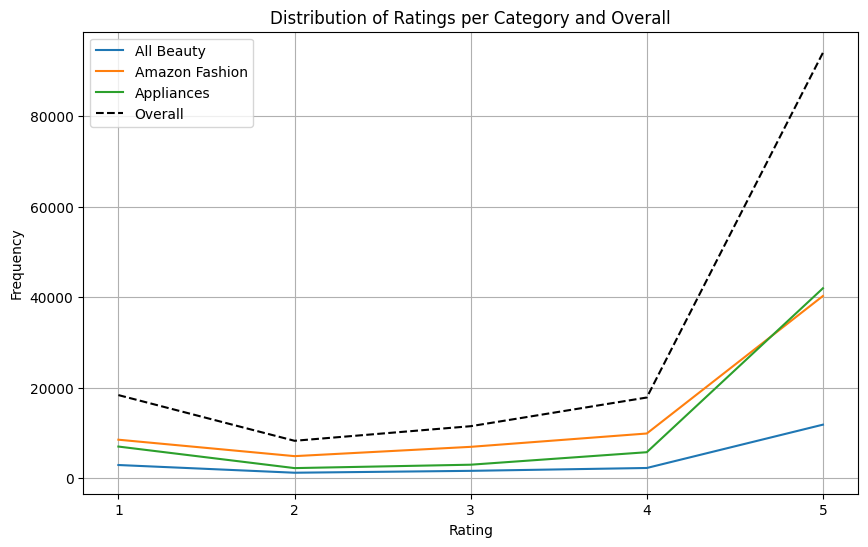

In [51]:
# Plotting in line chart
plt.figure(figsize=(10, 6))

# Plot each category's rating distribution
for category, ratings in rating_counts_per_category.iterrows():
    plt.plot(ratings.index, ratings.values, label=category)

# Plot overall rating distribution
plt.plot(overall_rating_counts.index, overall_rating_counts.values, label='Overall', linestyle='--', color='black')

# Set plot attributes
plt.title('Distribution of Ratings per Category and Overall')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.xticks(range(1, 6))
plt.legend()
plt.grid(True)

# Show plot
plt.show()

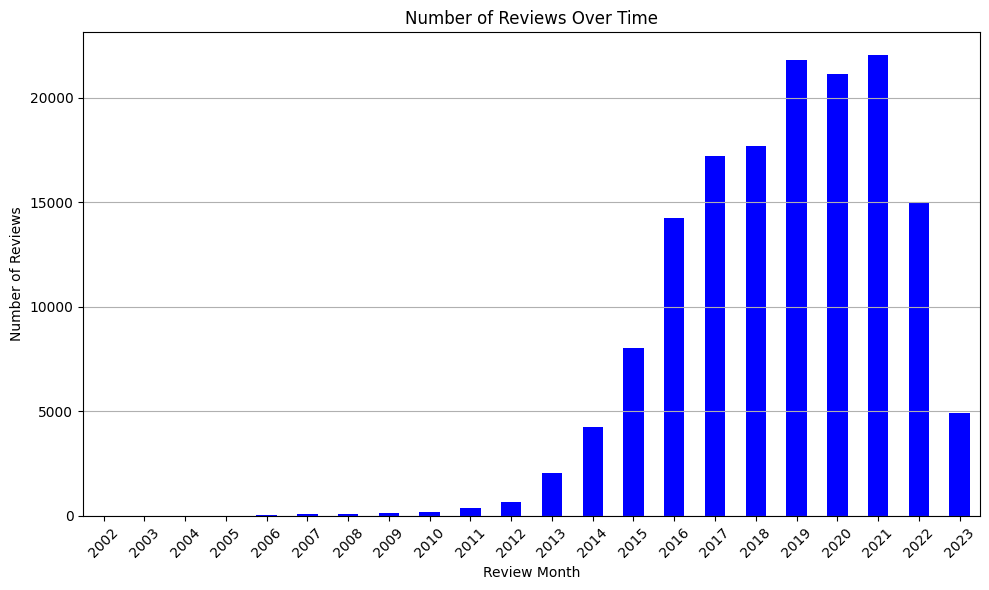

In [52]:
# Convert Review_Timestamp to month-year format
concatenated_df['Review_Month'] = concatenated_df['Review_Timestamp'].dt.to_period('Y')

# Group by Review_Month and count the number of reviews
review_counts = concatenated_df.groupby('Review_Month').size()

# Plotting the bar chart
plt.figure(figsize=(10, 6))
review_counts.plot(kind='bar', color='blue')
plt.title('Number of Reviews Over Time')
plt.xlabel('Review Month')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [53]:
#Creating a common review_id
concatenated_df['Review_ID'] = concatenated_df.index + 1

### Save CSV and PKL

In [54]:
# Save to CSV
concatenated_df.to_csv('concatenated_df.csv', index=False)

# Save to pickle (pkl)
concatenated_df.to_pickle('concatenated_df.pkl')